In [1]:
import json
import pandas as pd

#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
limiter=6000


def read_data(path, limiter):
    """
    Args:
        path: path to dataset in jsonl file format
        limiter: number of rows

    Returns:
        data: json dict, where every line is one sample as json
    """
    with open(path) as file:
        data = [json.loads(next(file)) for x in range(limiter)]
    return data


def transform_dll_imports(json_sample):
    """
    Args:
        json_sample: one sample of dataset

    Returns:
        functions_dict: dict with all dll functions name with value True
    """
    imports = sample["imports"]
    functions_dict = {}
    for key in imports.keys():
        functions = imports[key]
        functions_with_values = {key.lower() + "-" + f_name: True for f_name in functions}
        functions_dict.update(functions_with_values)
    return functions_dict


def transform_dict(json_dict):
    """
    Args:
        json_dict: json dict with nested key-value, where value is list

    Returns:
        functions_dict: dict with value as a key and default value True
    """
    result_dict = {}
    for key in json_dict.keys():
        keys = json_dict[key]
        values_with_default = {key.lower() + "-" + f_name: True for f_name in keys}
        result_dict.update(values_with_default)
    return result_dict


def transform_list(json_list):
    """
    Args:
        json_list: json list of values

    Returns:
        functions_dict: dict with all dll functions name with value True
    """
    result_dict = {}
    result_dict.update({i: True for i in json_list})
    return result_dict


def flatten_json(y, separator=''):
    """
    Args:
        y: json object
        separator: separator

    Returns:
        functions_dict: dict with flatten values
    """
    out = {}

    def flatten(x, name=separator):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out



# Extract "sha256", "md5", "appeared", "label" and "avclass" columns to a flat form

def get_simple_column(sample, columns = ["sha256", "md5", "appeared", "label", "avclass"]):
    '''
    input:
        data: variable with dataset
        columns: list of names extracted columns
    output:
        final_list: list of dicts, one list's element is a one sample of dataset
    '''
    simple_dict = {}
    simple_dict.update({column:sample[column] for column in columns})
    return simple_dict


# Extraction columns with list: "histogram", "byteentropy", "exports"

def get_simple_list_from_column(sample, columns = ["histogram", "byteentropy", "exports"]):

    '''
    input:
        data: variable with dataset
        columns: name of extracted columns (str)
    output:
        final_list: list of dicts, one list's element is a one sample of dataset
    '''
  
    dict_exports = {}
    dict_others = {}
    dict_final = {}

    for column in columns:
        if column == "exports":
            dict_exports.update({column+"_"+str(v).lower():True for v in sample[column]})
        else:
            dict_others.update({column+"_"+str(i):n for i, n in enumerate(sample[column])})             
                
    dict_final.update(dict_others)
    dict_final.update(dict_exports)
               
    return dict_final


# Extraction IMPORTS, GENERAL and STRINGS columns

def get_features_from_dict_column(sample, columns = "imports"):
    '''
    input:
            data
            columns
    output:
            functions_with_valuex
    '''
    dict_final = {}
    temp1 = {}
    temp2 = {}
    temp3 = {}

    feature = sample[columns]
    for key in feature.keys():
        content = feature[key]
        if (isinstance(content, list) and len(content)!=0):
            if not isinstance(content[0], str):
                temp1.update({columns +"_"+key.lower() + "-" + str(i):cont for i, cont in enumerate(content)})
            else:
                temp2.update({columns +"_"+ key.lower() + "-" + str(cont).lower():True for cont in content})
        else:
            temp3.update({columns+"_"+key:content})

    dict_final.update(temp1)   
    dict_final.update(temp2) 
    dict_final.update(temp3) 
    return dict_final


# Extraction HEADER column

def get_features_from_header(sample):
    '''
    input:
        data: data
    output:
        list_final: list of dicts
    '''    
    headers = sample["header"]
    dict_lists = {}
    dict_others = {}
    dict_final = {}

    for h in headers.keys():   
        temp = headers[h]      
        for k in temp.keys():  

            if isinstance(temp[k], list):
                dict_lists.update({"header_"+h.lower()+"_"+k.lower()+"_"+str(t).lower():True for t in temp[k]}) 
            else:
                dict_others.update({"header_"+h.lower()+"_"+k.lower():temp[k]})

    dict_final.update(dict_lists)    
    dict_final.update(dict_others)
    return dict_final


# Extraction Section column

def get_features_from_section(sample):

    '''
    input:
        data: data
    output:
        list_final: list of dicts
    '''  
    section_entry = sample['section']['entry']    # .text
    section_sections = sample['section']['sections']
    dict_lists_sections = {}
    dict_others_sections = {}
    dict_final = {}

    for part in section_sections:
        name = part['name']
        for position in ['size', 'entropy', 'vsize', 'props']:
            if position == 'props':
                dict_lists_sections.update({"section_"+section_entry.lower()+"_sections"+name.lower()+"_"+position+"_"+str(element).lower():True for element in part[position]})
            else:
                dict_others_sections.update({"section_"+section_entry.lower()+"_sections"+name.lower()+"_"+position:part[position]})
    dict_final.update(dict_lists_sections)
    dict_final.update(dict_others_sections)
    return dict_final


# Extraction DATADIRECTORIES column

def get_features_from_datadirectories(sample):
    '''
    input:
        data: data
    output:
        sum_others_datadir: list of dicts
    '''  

    dict_others_datadir = {}
    datadir = sample["datadirectories"]

    for element in datadir:
        element_name = element['name']
        for position in ['size', 'virtual_address']:
            dict_others_datadir.update({"datadirectories_"+element_name+"_"+position:element[position]})
    return dict_others_datadir




# loading dataset

In [2]:
# 1. read datas
data_path = r"D:\Pobrane\sample_data_6k.jsonl"
data = read_data(data_path, limiter=3500)
# 2. iterate over dataset
flatten_dataset = []
for sample in data:
    # version 1 dummy way
    # flat = flatten_json(sample)
    # flatten_dataset.append(flat)
    # collect transformed values for each sample

    # version 2
    transformed = {}

    transformed.update(get_simple_column(sample))
    transformed.update(get_simple_list_from_column(sample))
    transformed.update(get_features_from_dict_column(sample, columns = "strings"))
    transformed.update(get_features_from_dict_column(sample, columns = "general"))
    transformed.update(get_features_from_dict_column(sample, columns = "imports"))
    transformed.update(get_features_from_header(sample))
    transformed.update(get_features_from_section(sample))
    transformed.update(get_features_from_datadirectories(sample))


    # here we fill with transform data
    flatten_dataset.append(transformed)

# change all transformed dataset to dataframe object
df = pd.DataFrame(flatten_dataset)
df

,sha256,md5,appeared,label,avclass,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,...,imports_api-ms-win-core-marshal-l1-1-0.dll-hmenu_userfree,imports_api-ms-win-core-marshal-l1-1-0.dll-hicon_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_usersize,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_usermarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmenu_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hicon_usermarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_usersize,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_userfree,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_userfree
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,63956d6417f8f43357d9a8e79e52257e,2006-12,0,,45521,13095,12167,12496,12429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,6f7bde7a1126debf0cc359a54953efc1,2007-01,0,,93059,15789,2871,3005,4107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,7520c8f9534ca818726a4feaebf49e2b,2007-02,0,,45369,2560,1233,1542,4234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,e435a536968941854bcec3b902c439f6,2007-02,0,,21315,9641,9332,9358,9598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,e93049e2df82ab26f35ad0049173cb14,2007-02,0,,23539,6015,5214,4727,4892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,d3cfa11ea3b1adfe9c18b44c593be7bcb6188aea72f40d...,2ae322035cf8d1ad8a277d4c47cd1e36,2018-05,0,,88400,21752,25519,29419,31436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3496,654932edc2359b896eba1ef84a38f2791392493fac034a...,34adf3482b29e9d135c3b2d59b573220,2018-05,-1,,71670,3641,1911,2185,3435,...,True,True,True,True,True,True,True,True,True,True
3497,64040347b859880089f7536034b68724920796ad8c8d02...,d20d503ee9aee24883b840cdbeaee8d5,2018-05,0,,41434,13026,12966,13080,14093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3498,35cd7f66e96a381d64835ca854130d0c6787219664c28d...,f245942ea17d43b71e113d6a5afd88f2,2018-05,0,,135008,4584,4310,3843,3547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### removing data with label = -1

In [3]:
df_labeled = df[df['label'] != -1]  
df_labeled.shape

(2854, 158725)

### selecting only datadirectories columns

In [4]:
filter_col = [col for col in df_labeled if col.startswith('datadire')]

In [5]:
filter_col

['datadirectories_EXPORT_TABLE_size',
 'datadirectories_EXPORT_TABLE_virtual_address',
 'datadirectories_IMPORT_TABLE_size',
 'datadirectories_IMPORT_TABLE_virtual_address',
 'datadirectories_RESOURCE_TABLE_size',
 'datadirectories_RESOURCE_TABLE_virtual_address',
 'datadirectories_EXCEPTION_TABLE_size',
 'datadirectories_EXCEPTION_TABLE_virtual_address',
 'datadirectories_CERTIFICATE_TABLE_size',
 'datadirectories_CERTIFICATE_TABLE_virtual_address',
 'datadirectories_BASE_RELOCATION_TABLE_size',
 'datadirectories_BASE_RELOCATION_TABLE_virtual_address',
 'datadirectories_DEBUG_size',
 'datadirectories_DEBUG_virtual_address',
 'datadirectories_ARCHITECTURE_size',
 'datadirectories_ARCHITECTURE_virtual_address',
 'datadirectories_GLOBAL_PTR_size',
 'datadirectories_GLOBAL_PTR_virtual_address',
 'datadirectories_TLS_TABLE_size',
 'datadirectories_TLS_TABLE_virtual_address',
 'datadirectories_LOAD_CONFIG_TABLE_size',
 'datadirectories_LOAD_CONFIG_TABLE_virtual_address',
 'datadirectories_B

In [6]:
data_directories = df_labeled[filter_col]

In [7]:
data_directories.shape

(2854, 30)

In [8]:
data_directories['datadirectories_ARCHITECTURE_size']

0       0
1       0
2       0
3       0
4       0
       ..
3494    0
3495    0
3497    0
3498    0
3499    0
Name: datadirectories_ARCHITECTURE_size, Length: 2854, dtype: int64

### adding label column

In [9]:
data_directories['label'] = df_labeled['label']

C:\Users\Marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
data_directories['label']

0       0
1       0
2       0
3       0
4       0
       ..
3494    1
3495    0
3497    0
3498    0
3499    1
Name: label, Length: 2854, dtype: int64

In [11]:
data_directories.shape

(2854, 31)

In [12]:
data_directories.iloc[:1,:]

,datadirectories_EXPORT_TABLE_size,datadirectories_EXPORT_TABLE_virtual_address,datadirectories_IMPORT_TABLE_size,datadirectories_IMPORT_TABLE_virtual_address,datadirectories_RESOURCE_TABLE_size,datadirectories_RESOURCE_TABLE_virtual_address,datadirectories_EXCEPTION_TABLE_size,datadirectories_EXCEPTION_TABLE_virtual_address,datadirectories_CERTIFICATE_TABLE_size,datadirectories_CERTIFICATE_TABLE_virtual_address,...,datadirectories_LOAD_CONFIG_TABLE_virtual_address,datadirectories_BOUND_IMPORT_size,datadirectories_BOUND_IMPORT_virtual_address,datadirectories_IAT_size,datadirectories_IAT_virtual_address,datadirectories_DELAY_IMPORT_DESCRIPTOR_size,datadirectories_DELAY_IMPORT_DESCRIPTOR_virtual_address,datadirectories_CLR_RUNTIME_HEADER_size,datadirectories_CLR_RUNTIME_HEADER_virtual_address,label
0,0,0,200,35312,28672,352256,0,0,0,0,...,35240,0,0,660,32768,0,0,0,0,0


### histogram of datadirectories['datadirectories_EXPORT_TABLE_size']

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0.

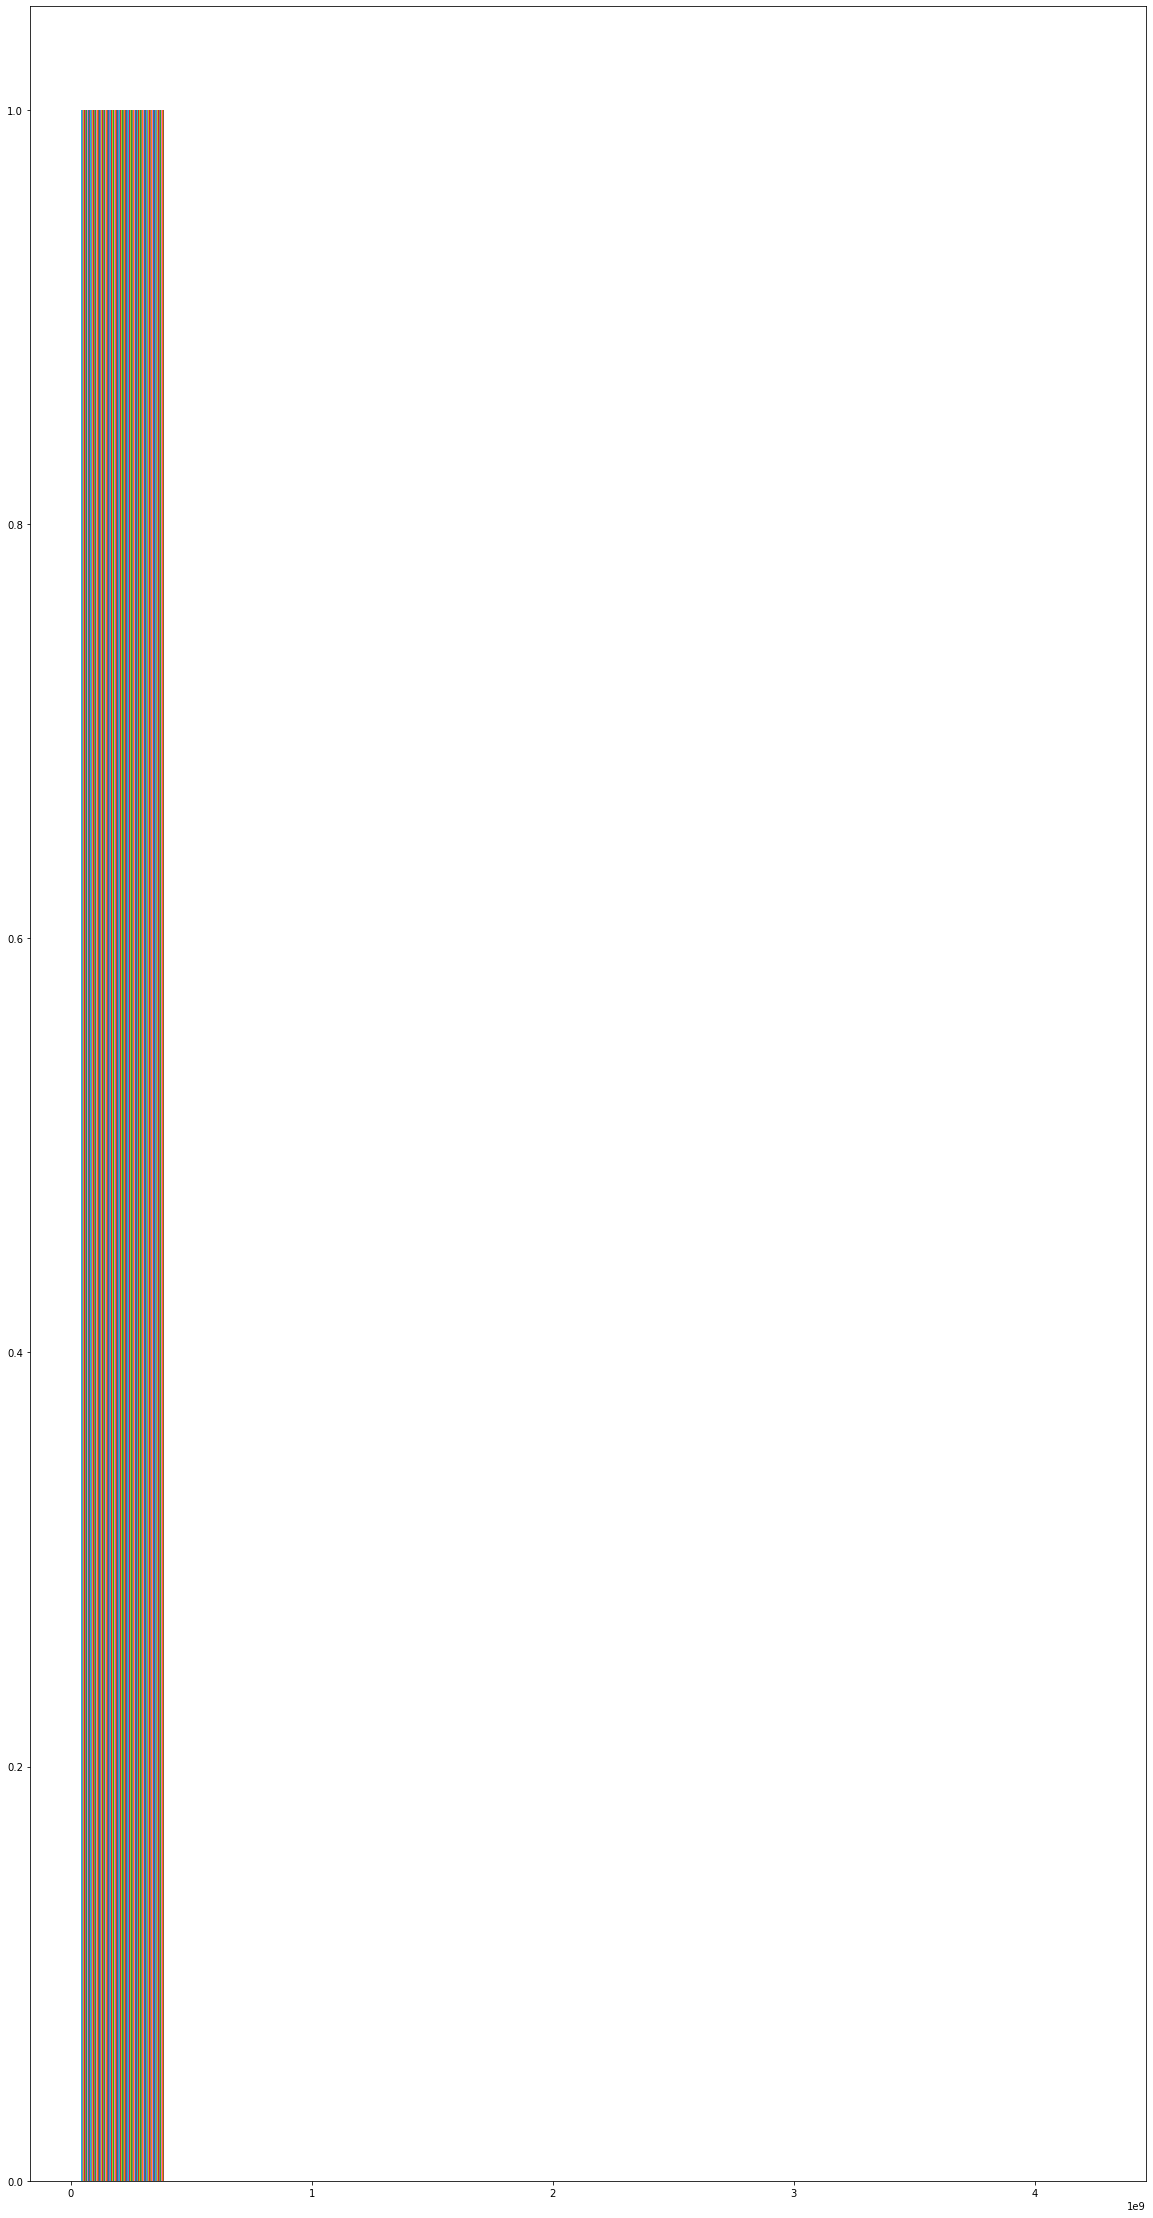

In [13]:
plt.figure(figsize = (20,40))

plt.hist(data_directories.iloc[:,0:1])

In [14]:
def data_remove_outliers(variable):
    
    data_without_outliers=data_directories[np.abs(data_directories[variable]-data_directories[variable].mean()) <= (3*data_directories[variable].std())]
    print('Number of outliers have been removed:', len(data_directories)-len(remove_outliers(variable)))

In [15]:
def plot_hist_without_outliers(variable, bins=50):
    plt.figure(figsize = (9,3))
    plt.hist((data_directories[np.abs(data_directories[variable]-data_directories[variable].mean()) <= (3*data_directories[variable].std())])[variable], bins)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution without outliers with hist".format(variable))
    plt.show()

## histograms of all columns (without outliers)

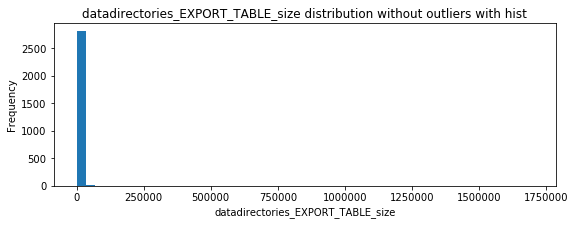

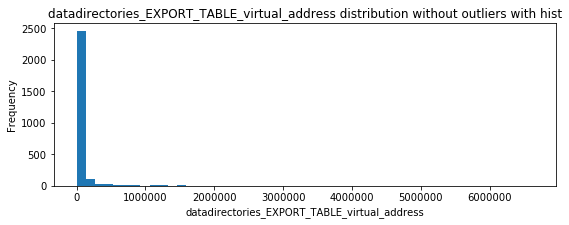

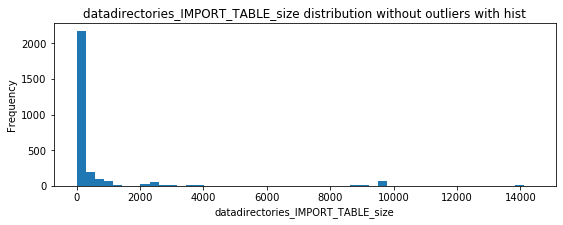

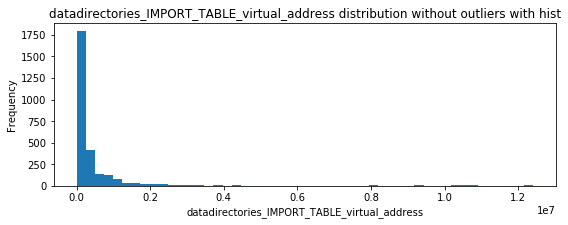

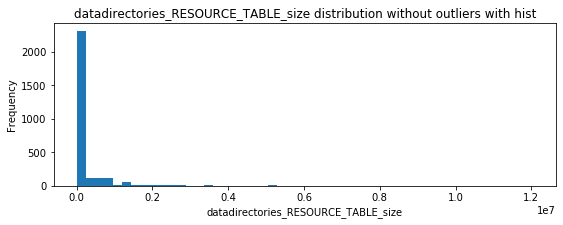

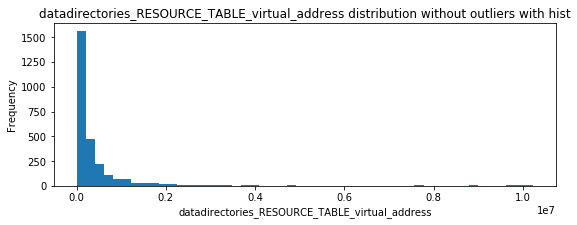

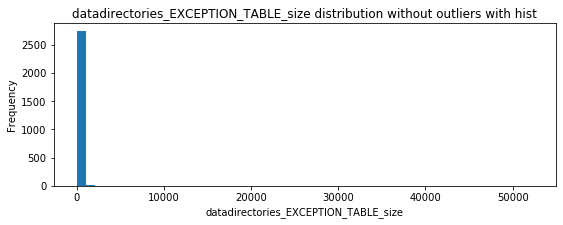

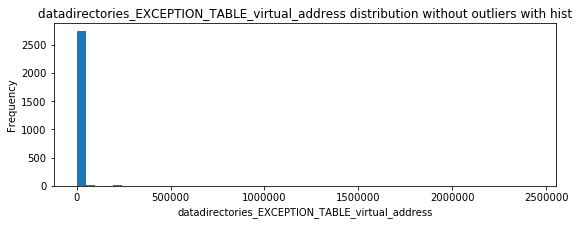

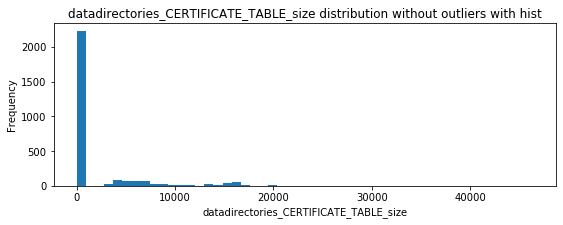

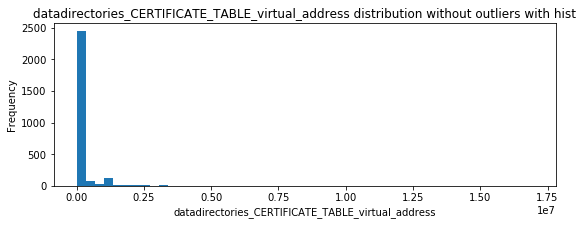

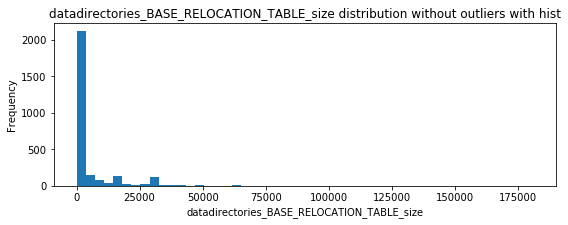

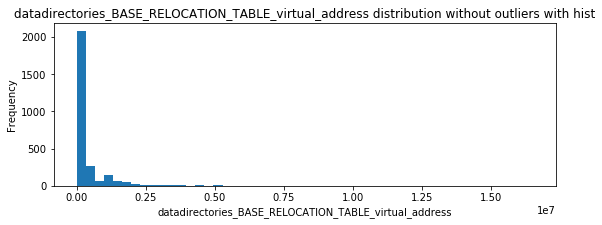

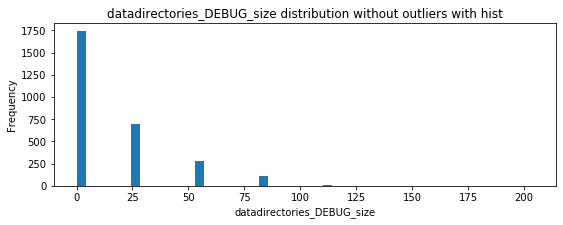

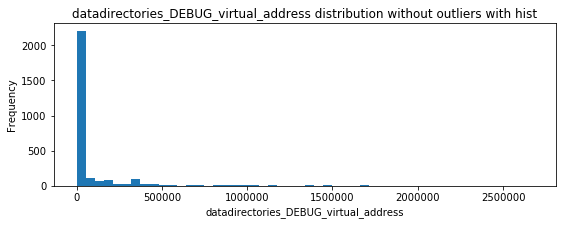

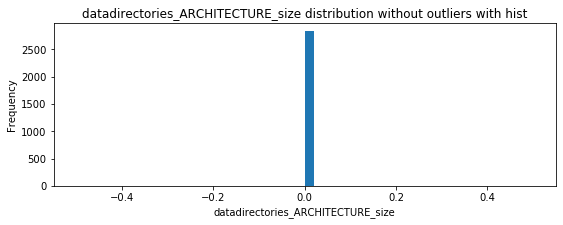

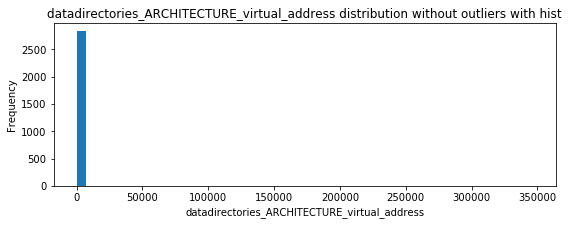

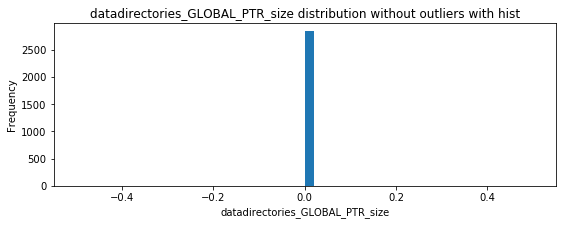

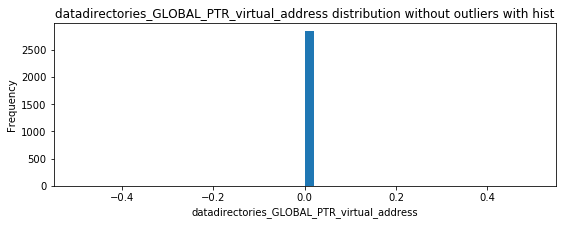

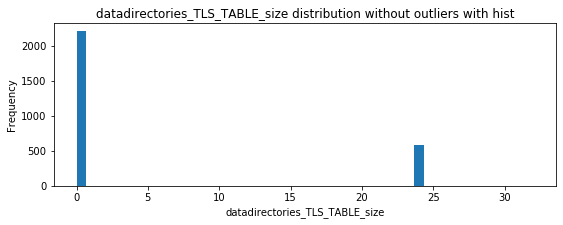

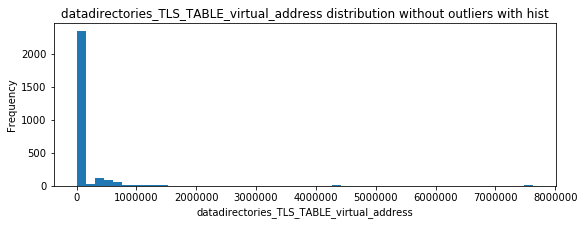

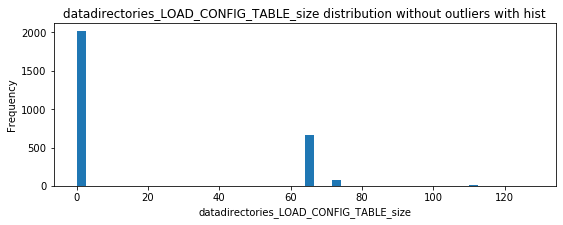

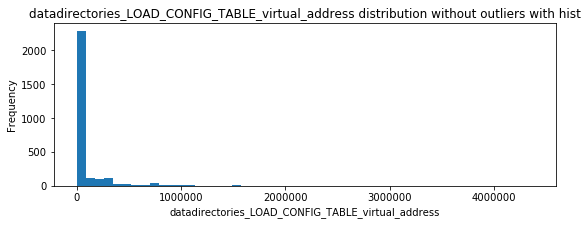

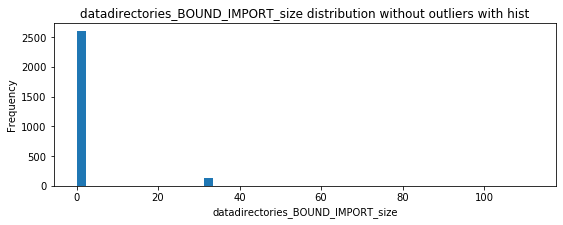

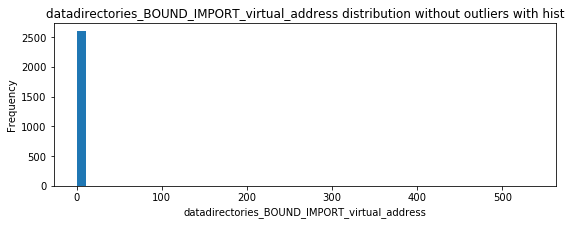

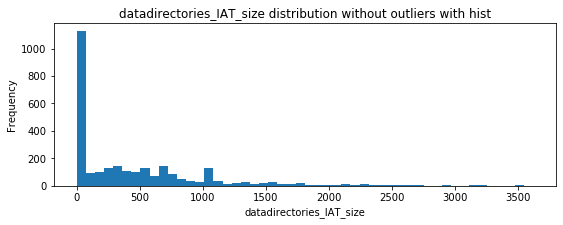

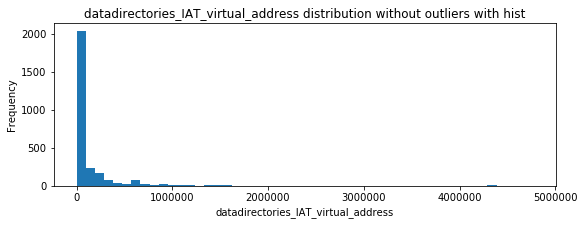

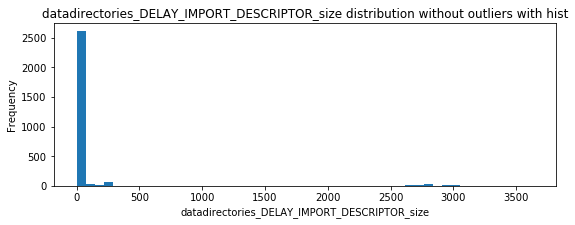

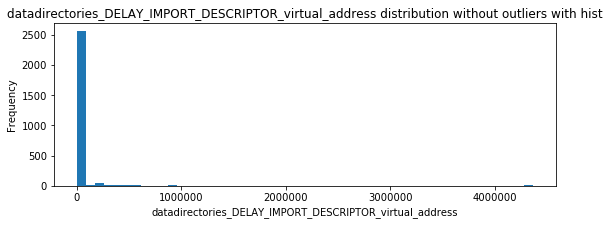

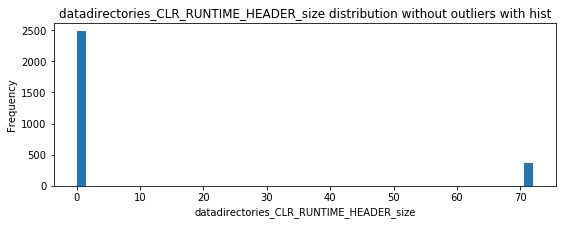

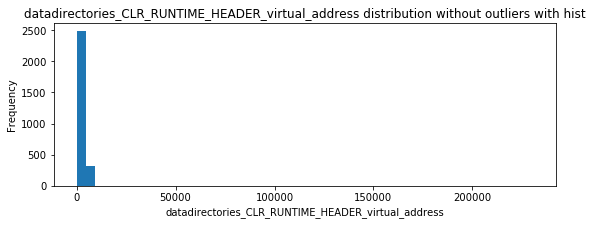

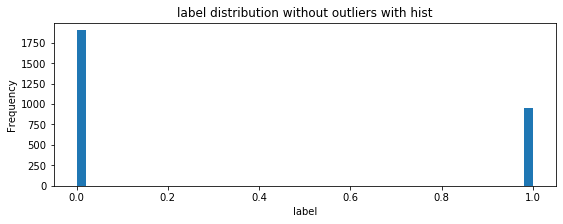

In [16]:
for sample in data_directories:
    plot_hist_without_outliers(sample)

# max value in each column

In [94]:
max_in_row = []
for i in range(len(data_directories.loc[0])):
    max_in_row.append(data_directories.iloc[:,i].max())

In [92]:
max_in_row

[352256,
 483328,
 172032,
 65536,
 1116436,
 24576,
 6522016,
 32768,
 17551360,
 192512,
 65536,
 65536,
 4096000,
 416624,
 143408,
 106336,
 1032192,
 258048,
 330592,
 1109152,
 1693400,
 65536,
 53248,
 659456,
 6619136,
 544768,
 69632,
 65536,
 65536,
 299712,
 2072576]

In [113]:
max_in_row = pd.DataFrame(max_in_row)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
max_in_row.describe()

,0
count,31.000
mean,172721139.968
std,767206198.600
min,0.000
25%,638.000
50%,2318436.000
75%,69641256.000
max,4294967295.000


# Correlation between columns

In [114]:
corrmat = data_directories.corr() 

In [115]:
data_directories['label']

0       0
1       0
2       0
3       0
4       0
       ..
3494    1
3495    0
3497    0
3498    0
3499    1
Name: label, Length: 2854, dtype: int64

In [116]:
data_directories.iloc[:3,:]

,datadirectories_EXPORT_TABLE_size,datadirectories_EXPORT_TABLE_virtual_address,datadirectories_IMPORT_TABLE_size,datadirectories_IMPORT_TABLE_virtual_address,datadirectories_RESOURCE_TABLE_size,datadirectories_RESOURCE_TABLE_virtual_address,datadirectories_EXCEPTION_TABLE_size,datadirectories_EXCEPTION_TABLE_virtual_address,datadirectories_CERTIFICATE_TABLE_size,datadirectories_CERTIFICATE_TABLE_virtual_address,...,datadirectories_LOAD_CONFIG_TABLE_virtual_address,datadirectories_BOUND_IMPORT_size,datadirectories_BOUND_IMPORT_virtual_address,datadirectories_IAT_size,datadirectories_IAT_virtual_address,datadirectories_DELAY_IMPORT_DESCRIPTOR_size,datadirectories_DELAY_IMPORT_DESCRIPTOR_virtual_address,datadirectories_CLR_RUNTIME_HEADER_size,datadirectories_CLR_RUNTIME_HEADER_virtual_address,label
0,0,0,200,35312,28672,352256,0,0,0,0,...,35240,0,0,660,32768,0,0,0,0,0
1,0,0,420,443376,38992,483328,0,0,0,0,...,92936,408,608,2604,4096,224,442296,0,0,0
2,0,0,216,78912,80512,90112,0,0,0,0,...,0,0,0,1120,4096,192,37280,0,0,0


In [117]:
#data_directories.info()

In [118]:
#pd.to_numeric(data_directories['label']) #jakby cos nie dzialalo to to zakomentowalem

In [119]:
corrmat

,datadirectories_EXPORT_TABLE_size,datadirectories_EXPORT_TABLE_virtual_address,datadirectories_IMPORT_TABLE_size,datadirectories_IMPORT_TABLE_virtual_address,datadirectories_RESOURCE_TABLE_size,datadirectories_RESOURCE_TABLE_virtual_address,datadirectories_EXCEPTION_TABLE_size,datadirectories_EXCEPTION_TABLE_virtual_address,datadirectories_CERTIFICATE_TABLE_size,datadirectories_CERTIFICATE_TABLE_virtual_address,...,datadirectories_LOAD_CONFIG_TABLE_virtual_address,datadirectories_BOUND_IMPORT_size,datadirectories_BOUND_IMPORT_virtual_address,datadirectories_IAT_size,datadirectories_IAT_virtual_address,datadirectories_DELAY_IMPORT_DESCRIPTOR_size,datadirectories_DELAY_IMPORT_DESCRIPTOR_virtual_address,datadirectories_CLR_RUNTIME_HEADER_size,datadirectories_CLR_RUNTIME_HEADER_virtual_address,label
datadirectories_EXPORT_TABLE_size,1.000,-0.008,-0.007,-0.008,-0.003,-0.009,-0.003,-0.003,-0.004,-0.005,...,-0.004,-0.008,-0.011,-0.012,-0.004,-0.004,-0.008,-0.014,-0.003,0.053
datadirectories_EXPORT_TABLE_virtual_address,-0.008,1.000,0.059,0.561,0.008,0.633,0.154,0.247,0.036,0.035,...,0.112,-0.044,-0.064,0.138,0.164,0.500,0.820,-0.084,-0.005,0.152
datadirectories_IMPORT_TABLE_size,-0.007,0.059,1.000,0.059,0.022,0.073,0.027,0.027,-0.006,0.006,...,-0.016,-0.044,-0.068,0.171,0.109,0.148,0.046,-0.088,-0.017,0.058
datadirectories_IMPORT_TABLE_virtual_address,-0.008,0.561,0.059,1.000,0.223,0.896,0.137,0.169,0.021,0.182,...,0.682,-0.038,-0.050,0.080,0.437,0.306,0.494,-0.060,-0.002,0.128
datadirectories_RESOURCE_TABLE_size,-0.003,0.008,0.022,0.223,1.000,0.146,0.019,0.008,0.308,0.712,...,0.276,-0.018,-0.027,0.049,0.015,0.009,0.017,-0.035,-0.007,0.014
datadirectories_RESOURCE_TABLE_virtual_address,-0.009,0.633,0.073,0.896,0.146,1.000,0.192,0.242,0.029,0.129,...,0.490,-0.047,-0.061,0.147,0.542,0.363,0.592,-0.073,0.010,0.140
datadirectories_EXCEPTION_TABLE_size,-0.003,0.154,0.027,0.137,0.019,0.192,1.000,0.814,0.108,0.088,...,0.294,-0.019,-0.027,0.208,0.252,-0.004,0.025,-0.002,0.210,-0.042
datadirectories_EXCEPTION_TABLE_virtual_address,-0.003,0.247,0.027,0.169,0.008,0.242,0.814,1.000,0.160,0.078,...,0.395,-0.018,-0.026,0.184,0.291,-0.006,0.011,-0.021,0.068,-0.028
datadirectories_CERTIFICATE_TABLE_size,-0.004,0.036,-0.006,0.021,0.308,0.029,0.108,0.160,1.000,0.276,...,0.080,-0.024,-0.034,0.090,0.029,-0.009,-0.011,-0.001,-0.002,-0.046
datadirectories_CERTIFICATE_TABLE_virtual_address,-0.005,0.035,0.006,0.182,0.712,0.129,0.088,0.078,0.276,1.000,...,0.247,-0.026,-0.038,0.061,0.034,-0.007,0.025,-0.042,-0.004,-0.044


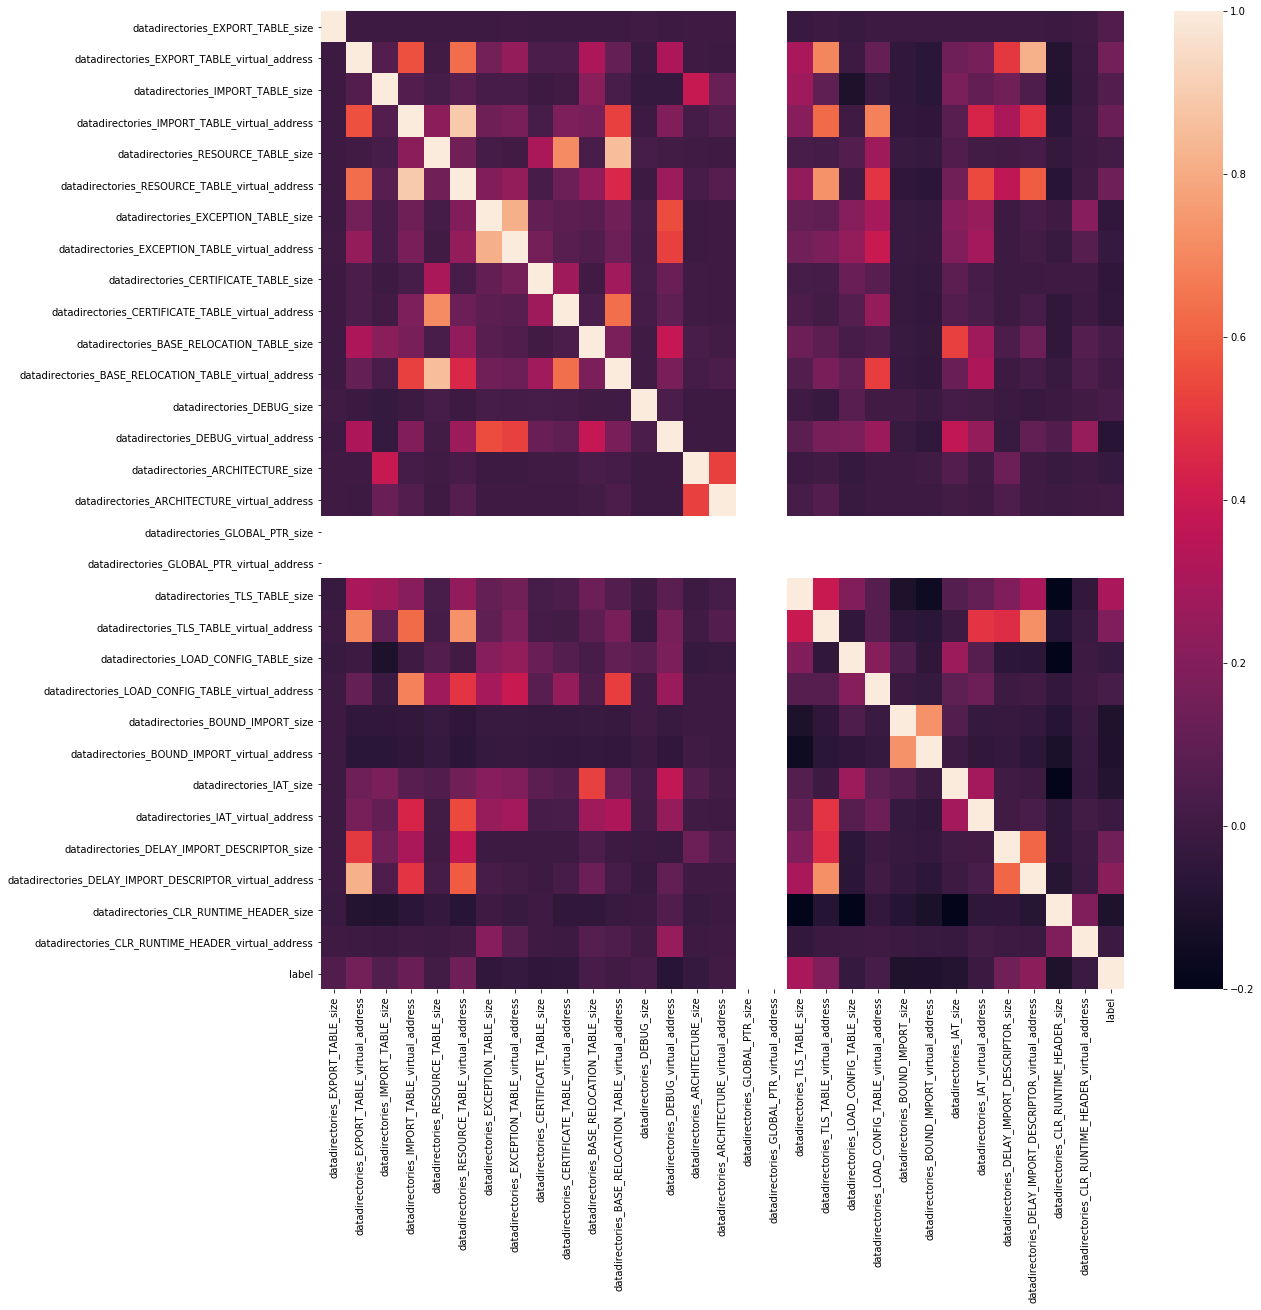

In [120]:
fig, ax = plt.subplots()
fig.set_size_inches(18,18)
sns.heatmap(corrmat)

As we can see there are really strong correlation (like 0.6 or even higher) between some datadirectories.

In [121]:
corrmat.columns

Index(['datadirectories_EXPORT_TABLE_size',
       'datadirectories_EXPORT_TABLE_virtual_address',
       'datadirectories_IMPORT_TABLE_size',
       'datadirectories_IMPORT_TABLE_virtual_address',
       'datadirectories_RESOURCE_TABLE_size',
       'datadirectories_RESOURCE_TABLE_virtual_address',
       'datadirectories_EXCEPTION_TABLE_size',
       'datadirectories_EXCEPTION_TABLE_virtual_address',
       'datadirectories_CERTIFICATE_TABLE_size',
       'datadirectories_CERTIFICATE_TABLE_virtual_address',
       'datadirectories_BASE_RELOCATION_TABLE_size',
       'datadirectories_BASE_RELOCATION_TABLE_virtual_address',
       'datadirectories_DEBUG_size', 'datadirectories_DEBUG_virtual_address',
       'datadirectories_ARCHITECTURE_size',
       'datadirectories_ARCHITECTURE_virtual_address',
       'datadirectories_GLOBAL_PTR_size',
       'datadirectories_GLOBAL_PTR_virtual_address',
       'datadirectories_TLS_TABLE_size',
       'datadirectories_TLS_TABLE_virtual_address',
   

## Correlation between datadirectories and label

In [122]:
corrmat['label']

datadirectories_EXPORT_TABLE_size                          0.053
datadirectories_EXPORT_TABLE_virtual_address               0.152
datadirectories_IMPORT_TABLE_size                          0.058
datadirectories_IMPORT_TABLE_virtual_address               0.128
datadirectories_RESOURCE_TABLE_size                        0.014
datadirectories_RESOURCE_TABLE_virtual_address             0.140
datadirectories_EXCEPTION_TABLE_size                      -0.042
datadirectories_EXCEPTION_TABLE_virtual_address           -0.028
datadirectories_CERTIFICATE_TABLE_size                    -0.046
datadirectories_CERTIFICATE_TABLE_virtual_address         -0.044
datadirectories_BASE_RELOCATION_TABLE_size                 0.027
datadirectories_BASE_RELOCATION_TABLE_virtual_address      0.009
datadirectories_DEBUG_size                                 0.028
datadirectories_DEBUG_virtual_address                     -0.069
datadirectories_ARCHITECTURE_size                         -0.030
datadirectories_ARCHITECT

In [123]:
## sorted correlation between datadirectories and label

In [124]:
{k: v for k, v in sorted(corrmat['label'].items(), key=lambda item: item[1])}

{'datadirectories_BOUND_IMPORT_size': -0.10594800830570983,
 'datadirectories_CLR_RUNTIME_HEADER_size': -0.10391852687374144,
 'datadirectories_BOUND_IMPORT_virtual_address': -0.09727750495235353,
 'datadirectories_IAT_size': -0.0859877412985729,
 'datadirectories_DEBUG_virtual_address': -0.06913035201186538,
 'datadirectories_CERTIFICATE_TABLE_size': -0.045682917213408045,
 'datadirectories_CERTIFICATE_TABLE_virtual_address': -0.04390506366689888,
 'datadirectories_EXCEPTION_TABLE_size': -0.04226201972862339,
 'datadirectories_ARCHITECTURE_size': -0.03018081597606842,
 'datadirectories_EXCEPTION_TABLE_virtual_address': -0.02845189082670936,
 'datadirectories_LOAD_CONFIG_TABLE_size': -0.02701191620068565,
 'datadirectories_CLR_RUNTIME_HEADER_virtual_address': -0.015985016707983708,
 'datadirectories_IAT_virtual_address': -0.013892638285986789,
 'datadirectories_BASE_RELOCATION_TABLE_virtual_address': 0.009302853595703339,
 'datadirectories_ARCHITECTURE_virtual_address': 0.0093588863956

# Logistic Regression

In [125]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [126]:
X_train, X_test, y_train, y_test = train_test_split(data_directories['datadirectories_ARCHITECTURE_virtual_address'], data_directories['label'], train_size=0.5)

In [127]:
y_train1 = y_train.values.reshape(-1,1);
X_train1 = X_train.values.reshape(-1,1);

In [128]:
clf = LogisticRegression(random_state=0).fit(X_train1, y_train1.ravel())

In [129]:
from sklearn.metrics import accuracy_score

In [130]:
X_test1 = X_test.values.reshape(-1,1);

In [131]:
y_predicted = clf.predict(X_test1)

In [132]:
y_test.shape

(1427,)

In [133]:
accuracy_score(y_test, y_predicted)

0.6664330763840224

In [134]:
(y_test==y_predicted).sum(), (y_test!=y_predicted).sum()

(951, 476)

In [135]:
y_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [136]:
(y_predicted==0).sum(), (y_predicted==1).sum(), y_predicted.shape

(1424, 3, (1427,))

#### number of zeros and ones in all dataset

In [137]:
(data_directories['label']==1).sum(), (data_directories['label']==0).sum()

(955, 1899)

# Sampling

#### function to create balanced dataset (with the same numer of ones and zeros)

In [138]:
import sklearn
from imblearn.under_sampling import RandomUnderSampler
import imblearn; imblearn.show_versions(github=True)
rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_sample(data_directories.iloc[:,:30], data_directories['label'])

<details><summary>System, Dependency Information</summary>

**System Information**

* python    : `3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]`
* executable: `C:\Users\Marcin\Miniconda3\python.exe`
* machine   : `Windows-10-10.0.19041-SP0`

**Python Dependencies**

* pip       : `20.3.3`
* setuptools: `52.0.0.post20210125`
* imblearn  : `0.7.0`
* sklearn   : `0.23.2`
* numpy     : `1.18.1`
* scipy     : `1.6.0`
* Cython    : `None`
* pandas    : `1.0.1`
* keras     : `None`
* tensorflow: `None`
* joblib    : `1.0.0`

</details>


In [139]:
X_rus

,datadirectories_EXPORT_TABLE_size,datadirectories_EXPORT_TABLE_virtual_address,datadirectories_IMPORT_TABLE_size,datadirectories_IMPORT_TABLE_virtual_address,datadirectories_RESOURCE_TABLE_size,datadirectories_RESOURCE_TABLE_virtual_address,datadirectories_EXCEPTION_TABLE_size,datadirectories_EXCEPTION_TABLE_virtual_address,datadirectories_CERTIFICATE_TABLE_size,datadirectories_CERTIFICATE_TABLE_virtual_address,...,datadirectories_LOAD_CONFIG_TABLE_size,datadirectories_LOAD_CONFIG_TABLE_virtual_address,datadirectories_BOUND_IMPORT_size,datadirectories_BOUND_IMPORT_virtual_address,datadirectories_IAT_size,datadirectories_IAT_virtual_address,datadirectories_DELAY_IMPORT_DESCRIPTOR_size,datadirectories_DELAY_IMPORT_DESCRIPTOR_virtual_address,datadirectories_CLR_RUNTIME_HEADER_size,datadirectories_CLR_RUNTIME_HEADER_virtual_address
0,0,0,75,146688,131512,147456,0,0,0,0,...,0,0,0,0,8,8192,0,0,72,8200
1,0,0,220,119364,606456,131072,0,0,0,0,...,0,0,0,0,2600,90112,0,0,0,0
2,0,0,1028,20480,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4474,118784,80,134960,1032,143360,2964,45056,0,0,...,0,0,0,0,1656,32768,0,0,0,0
4,0,0,160,36624,6660,114688,0,0,9608,1819136,...,0,0,0,0,460,8192,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,0,0,480,1100440,72552,1175552,0,0,23248,1263104,...,64,1054896,0,0,2036,929792,0,0,0,0
1906,0,0,220,463540,831088,491520,0,0,4736,1328640,...,64,443320,0,0,1028,290816,0,0,0,0
1907,0,0,340,676424,37636,868352,28380,811008,0,0,...,0,0,0,0,4280,602112,0,0,0,0
1908,0,0,79,197484,373984,245760,0,0,0,0,...,0,0,0,0,8,630784,0,0,72,196608


In [140]:
y_rus, y_rus.sum()

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1905    1
 1906    1
 1907    1
 1908    1
 1909    1
 Name: label, Length: 1910, dtype: int64,
 955)

# modelling after sampling

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_rus['datadirectories_EXPORT_TABLE_size'], y_rus, train_size=0.5)

In [142]:
y_train1 = y_train.values.reshape(-1,1);
X_train1 = X_train.values.reshape(-1,1);


X_train1.shape, y_train1.shape



((955, 1), (955, 1))

In [143]:
clf = LogisticRegression(random_state=0).fit(X_train1, y_train1.ravel())

X_test1 = X_test.values.reshape(-1,1);

y_predicted = clf.predict(X_test1)

accuracy_score(y_test, y_predicted)

0.4513089005235602

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_rus['datadirectories_EXPORT_TABLE_size'], y_rus, train_size=0.5)
y_train1 = y_train.values.reshape(-1,1);
X_train1 = X_train.values.reshape(-1,1);

y_train1.shape, X_train1.shape

((955, 1), (955, 1))

### logistic regression for all datadirectories columns

In [145]:
dicts = {}
for col in X_rus:
    X_train, X_test, y_train, y_test = train_test_split(X_rus[col], y_rus, train_size=0.5)
    y_train1 = y_train.values.reshape(-1,1);
    X_train1 = X_train.values.reshape(-1,1);

    clf = LogisticRegression(random_state=0).fit(X_train1, y_train1.ravel())

    X_test1 = X_test.values.reshape(-1,1);

    y_predicted = clf.predict(X_test1)

    dicts[col] = accuracy_score(y_test, y_predicted)
    #scores.append(accuracy_score(y_test, y_predicted))

In [146]:
dicts

{'datadirectories_EXPORT_TABLE_size': 0.47853403141361256,
 'datadirectories_EXPORT_TABLE_virtual_address': 0.4387434554973822,
 'datadirectories_IMPORT_TABLE_size': 0.5518324607329843,
 'datadirectories_IMPORT_TABLE_virtual_address': 0.5654450261780105,
 'datadirectories_RESOURCE_TABLE_size': 0.5528795811518324,
 'datadirectories_RESOURCE_TABLE_virtual_address': 0.4586387434554974,
 'datadirectories_EXCEPTION_TABLE_size': 0.47958115183246075,
 'datadirectories_EXCEPTION_TABLE_virtual_address': 0.4963350785340314,
 'datadirectories_CERTIFICATE_TABLE_size': 0.5246073298429319,
 'datadirectories_CERTIFICATE_TABLE_virtual_address': 0.5089005235602094,
 'datadirectories_BASE_RELOCATION_TABLE_size': 0.4931937172774869,
 'datadirectories_BASE_RELOCATION_TABLE_virtual_address': 0.4942408376963351,
 'datadirectories_DEBUG_size': 0.4942408376963351,
 'datadirectories_DEBUG_virtual_address': 0.5832460732984294,
 'datadirectories_ARCHITECTURE_size': 0.4931937172774869,
 'datadirectories_ARCHITECT

### sorted results of logistic regression

In [147]:
{k: v for k, v in sorted(dicts.items(), key=lambda item: item[1])}

{'datadirectories_EXPORT_TABLE_virtual_address': 0.4387434554973822,
 'datadirectories_RESOURCE_TABLE_virtual_address': 0.4586387434554974,
 'datadirectories_IAT_size': 0.47539267015706804,
 'datadirectories_EXPORT_TABLE_size': 0.47853403141361256,
 'datadirectories_EXCEPTION_TABLE_size': 0.47958115183246075,
 'datadirectories_LOAD_CONFIG_TABLE_size': 0.4900523560209424,
 'datadirectories_IAT_virtual_address': 0.49109947643979057,
 'datadirectories_BASE_RELOCATION_TABLE_size': 0.4931937172774869,
 'datadirectories_ARCHITECTURE_size': 0.4931937172774869,
 'datadirectories_GLOBAL_PTR_virtual_address': 0.4931937172774869,
 'datadirectories_BASE_RELOCATION_TABLE_virtual_address': 0.4942408376963351,
 'datadirectories_DEBUG_size': 0.4942408376963351,
 'datadirectories_EXCEPTION_TABLE_virtual_address': 0.4963350785340314,
 'datadirectories_ARCHITECTURE_virtual_address': 0.4963350785340314,
 'datadirectories_CLR_RUNTIME_HEADER_virtual_address': 0.4963350785340314,
 'datadirectories_GLOBAL_PTR

As we can see we get the best result for TLS Table. According to wikipedia: 
Transport Layer Security (TLS), and its now-deprecated predecessor, Secure Sockets Layer (SSL), are cryptographic protocols designed to provide communications security over a computer network.

In [148]:
X_rus.shape

(1910, 30)

### logistic regression for two 'best' columns

In [149]:
two_best_cols = X_rus[['datadirectories_TLS_TABLE_virtual_address', 'datadirectories_TLS_TABLE_size']]

In [150]:
two_best_cols.shape

(1910, 2)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(two_best_cols, y_rus, train_size=0.5)
#y_train1 = y_train.values.reshape(-1,1);
#X_train1 = X_train.values.reshape(-1,1);

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((955, 2), (955, 2), (955,), (955,))

In [152]:
y_train.shape, X_train.shape

((955,), (955, 2))

In [153]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train.ravel())

y_predicted = clf.predict(X_test)

accuracy_score(y_test, y_predicted)

0.6534031413612565

# decision tree

In [154]:
from sklearn import tree

In [155]:
clf_tree = tree.DecisionTreeClassifier()

In [156]:
clf_tree = clf_tree.fit(two_best_cols, y_rus)

In [157]:
two_best_cols.shape, y_rus.shape

((1910, 2), (1910,))

In [158]:
prediction = clf_tree.predict(X_test)

In [159]:
accuracy_score(y_test, prediction)

0.7109947643979058

### four best columns logistic regression

In [160]:
four_columns = X_rus[['datadirectories_TLS_TABLE_virtual_address', 'datadirectories_TLS_TABLE_size' ,'datadirectories_DEBUG_virtual_address' ,'datadirectories_IMPORT_TABLE_virtual_address']]
X_train, X_test, y_train, y_test = train_test_split(four_columns, y_rus, train_size=0.5)

clf = LogisticRegression(random_state=0).fit(X_train, y_train.ravel())

y_predicted = clf.predict(X_test)

accuracy_score(y_test, y_predicted)

0.6376963350785341

In [161]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((955, 4), (955, 4), (955,), (955,))

### fours best columns decision tree

In [162]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(four_columns, y_rus)
prediction = clf_tree.predict(X_test)
accuracy_score(y_test, prediction)

0.9685863874345549

really that good result? something must be wrong or the dataset we work on now is too small and records are really similar to each other

### six best columns logistic regression

In [163]:
six_columns = X_rus[['datadirectories_TLS_TABLE_virtual_address', 'datadirectories_TLS_TABLE_size' ,'datadirectories_DEBUG_virtual_address' ,'datadirectories_IMPORT_TABLE_virtual_address', 'datadirectories_IMPORT_TABLE_size', 'datadirectories_IAT_virtual_address']]
X_train, X_test, y_train, y_test = train_test_split(six_columns, y_rus, train_size=0.5)

clf = LogisticRegression(random_state=0).fit(X_train, y_train.ravel())

y_predicted = clf.predict(X_test)

accuracy_score(y_test, y_predicted)

0.5842931937172775

# six best columns decision tree

In [164]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(six_columns, y_rus)
prediction = clf_tree.predict(X_test)
accuracy_score(y_test, prediction)

0.9842931937172775

# checking dependency between datadirectories import table size and import

In [165]:
filter_col_dd = [col for col in df_labeled if col.startswith('datadire')]
filter_col_dd

['datadirectories_EXPORT_TABLE_size',
 'datadirectories_EXPORT_TABLE_virtual_address',
 'datadirectories_IMPORT_TABLE_size',
 'datadirectories_IMPORT_TABLE_virtual_address',
 'datadirectories_RESOURCE_TABLE_size',
 'datadirectories_RESOURCE_TABLE_virtual_address',
 'datadirectories_EXCEPTION_TABLE_size',
 'datadirectories_EXCEPTION_TABLE_virtual_address',
 'datadirectories_CERTIFICATE_TABLE_size',
 'datadirectories_CERTIFICATE_TABLE_virtual_address',
 'datadirectories_BASE_RELOCATION_TABLE_size',
 'datadirectories_BASE_RELOCATION_TABLE_virtual_address',
 'datadirectories_DEBUG_size',
 'datadirectories_DEBUG_virtual_address',
 'datadirectories_ARCHITECTURE_size',
 'datadirectories_ARCHITECTURE_virtual_address',
 'datadirectories_GLOBAL_PTR_size',
 'datadirectories_GLOBAL_PTR_virtual_address',
 'datadirectories_TLS_TABLE_size',
 'datadirectories_TLS_TABLE_virtual_address',
 'datadirectories_LOAD_CONFIG_TABLE_size',
 'datadirectories_LOAD_CONFIG_TABLE_virtual_address',
 'datadirectories_B

In [166]:
d_d = df_labeled[filter_col_dd]

In [167]:
(data_directories['datadirectories_IMPORT_TABLE_size']==0).sum()

237

In [168]:
data_directories_export_zero = data_directories[(data_directories['datadirectories_EXPORT_TABLE_size']==0)]

In [169]:
data_directories_export_zero

,datadirectories_EXPORT_TABLE_size,datadirectories_EXPORT_TABLE_virtual_address,datadirectories_IMPORT_TABLE_size,datadirectories_IMPORT_TABLE_virtual_address,datadirectories_RESOURCE_TABLE_size,datadirectories_RESOURCE_TABLE_virtual_address,datadirectories_EXCEPTION_TABLE_size,datadirectories_EXCEPTION_TABLE_virtual_address,datadirectories_CERTIFICATE_TABLE_size,datadirectories_CERTIFICATE_TABLE_virtual_address,...,datadirectories_LOAD_CONFIG_TABLE_virtual_address,datadirectories_BOUND_IMPORT_size,datadirectories_BOUND_IMPORT_virtual_address,datadirectories_IAT_size,datadirectories_IAT_virtual_address,datadirectories_DELAY_IMPORT_DESCRIPTOR_size,datadirectories_DELAY_IMPORT_DESCRIPTOR_virtual_address,datadirectories_CLR_RUNTIME_HEADER_size,datadirectories_CLR_RUNTIME_HEADER_virtual_address,label
0,0,0,200,35312,28672,352256,0,0,0,0,...,35240,0,0,660,32768,0,0,0,0,0
1,0,0,420,443376,38992,483328,0,0,0,0,...,92936,408,608,2604,4096,224,442296,0,0,0
2,0,0,216,78912,80512,90112,0,0,0,0,...,0,0,0,1120,4096,192,37280,0,0,0
3,0,0,2370,49152,10240,65536,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,140,35136,1116436,49152,0,0,0,0,...,0,0,0,520,4096,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,0,0,79,197484,373984,245760,0,0,0,0,...,0,0,0,8,630784,0,0,72,196608,1
3495,0,0,200,5557752,1225,8892416,0,0,15512,5512704,...,8887328,0,0,120,3735552,0,0,0,0,0
3497,0,0,100,193004,3642860,196608,0,0,15584,3837952,...,8896,0,0,488,192512,0,0,0,0,0
3498,0,0,79,886304,960,892928,0,0,984,880640,...,0,0,0,8,8192,0,0,72,8200,0


In [170]:
data_directories_import_zero = data_directories[(data_directories['datadirectories_IMPORT_TABLE_size']==0)]

In [171]:
data_directories_import_zero

,datadirectories_EXPORT_TABLE_size,datadirectories_EXPORT_TABLE_virtual_address,datadirectories_IMPORT_TABLE_size,datadirectories_IMPORT_TABLE_virtual_address,datadirectories_RESOURCE_TABLE_size,datadirectories_RESOURCE_TABLE_virtual_address,datadirectories_EXCEPTION_TABLE_size,datadirectories_EXCEPTION_TABLE_virtual_address,datadirectories_CERTIFICATE_TABLE_size,datadirectories_CERTIFICATE_TABLE_virtual_address,...,datadirectories_LOAD_CONFIG_TABLE_virtual_address,datadirectories_BOUND_IMPORT_size,datadirectories_BOUND_IMPORT_virtual_address,datadirectories_IAT_size,datadirectories_IAT_virtual_address,datadirectories_DELAY_IMPORT_DESCRIPTOR_size,datadirectories_DELAY_IMPORT_DESCRIPTOR_virtual_address,datadirectories_CLR_RUNTIME_HEADER_size,datadirectories_CLR_RUNTIME_HEADER_virtual_address,label
100,187,4160,0,0,1056,8192,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131,0,0,0,0,67412,4096,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,0,0,0,0,4228,4096,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172,0,0,0,0,19416,4096,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209,0,0,0,0,65896,8192,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0,0,0,0,23916,8192,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3459,0,0,0,0,6976,8192,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3460,0,0,0,0,11468,8192,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3482,0,0,0,0,1392,8192,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
filter_col_import = [col for col in df_labeled if col.startswith('import')]

In [173]:
imports = df_labeled[filter_col_import]

In [174]:
imports.iloc[100:101,:]

,imports_kernel32.dll-setfiletime,imports_kernel32.dll-comparefiletime,imports_kernel32.dll-searchpatha,imports_kernel32.dll-getshortpathnamea,imports_kernel32.dll-getfullpathnamea,imports_kernel32.dll-movefilea,imports_kernel32.dll-lstrcata,imports_kernel32.dll-setcurrentdirectorya,imports_kernel32.dll-getfileattributesa,imports_kernel32.dll-getlasterror,...,imports_api-ms-win-core-marshal-l1-1-0.dll-hmenu_userfree,imports_api-ms-win-core-marshal-l1-1-0.dll-hicon_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_usersize,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_usermarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmenu_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hicon_usermarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_usersize,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_userfree,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_userfree
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
suma_nan = imports.iloc[100:101,:].isna().sum()
suma_nan.sum()

72562

In [176]:
imports.iloc[131:132,:]

,imports_kernel32.dll-setfiletime,imports_kernel32.dll-comparefiletime,imports_kernel32.dll-searchpatha,imports_kernel32.dll-getshortpathnamea,imports_kernel32.dll-getfullpathnamea,imports_kernel32.dll-movefilea,imports_kernel32.dll-lstrcata,imports_kernel32.dll-setcurrentdirectorya,imports_kernel32.dll-getfileattributesa,imports_kernel32.dll-getlasterror,...,imports_api-ms-win-core-marshal-l1-1-0.dll-hmenu_userfree,imports_api-ms-win-core-marshal-l1-1-0.dll-hicon_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_usersize,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_usermarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmenu_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hicon_usermarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_usersize,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_userunmarshal,imports_api-ms-win-core-marshal-l1-1-0.dll-hmonitor_userfree,imports_api-ms-win-core-marshal-l1-1-0.dll-hbitmap_userfree
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
suma_nan_0 = imports.iloc[131:132,:].isna().sum()

In [178]:
suma_nan_0.sum()

72562

In [179]:
suma_nan_1 = imports.iloc[135:136,:].isna().sum()

In [180]:
suma_nan_1.sum()

72424

as we can see if a value in column datadirectories_IMPORT_TABLE_size is equal to zero, there are no imports (there are only NaN values in import columns)